# Installs:

In [2]:
!pip install ucimlrepo

# Imports:

In [3]:
from ucimlrepo import fetch_ucirepo
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, precision_score, recall_score, classification_report
from random import sample
from sklearn.preprocessing import OneHotEncoder

In [4]:
# fetch dataset
adult = fetch_ucirepo(id=2)

# data (as pandas dataframes)
X = adult.data.features
y = adult.data.targets

# metadata
print(adult.metadata)

# variable information
print(adult.variables)



{'uci_id': 2, 'name': 'Adult', 'repository_url': 'https://archive.ics.uci.edu/dataset/2/adult', 'data_url': 'https://archive.ics.uci.edu/static/public/2/data.csv', 'abstract': 'Predict whether income exceeds $50K/yr based on census data. Also known as "Census Income" dataset. ', 'area': 'Social Science', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 48842, 'num_features': 14, 'feature_types': ['Categorical', 'Integer'], 'demographics': ['Age', 'Income', 'Education Level', 'Other', 'Race', 'Sex'], 'target_col': ['income'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1996, 'last_updated': 'Mon Aug 07 2023', 'dataset_doi': '10.24432/C5XW20', 'creators': ['Barry Becker', 'Ronny Kohavi'], 'intro_paper': None, 'additional_info': {'summary': 'Extraction was done by Barry Becker from the 1994 Census database.  A set of reasonably clean records was extracted using the following conditions: ((AAG

# Read up on what the data means + Decisions

Each column meaning:

- age: A person's (datapoint's) age. This column is represented in integers.
- workclass: This column has missing data, is categorical, and represents the type of employment. Options include: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked.
- fnlwgt: This column represents how many people the census believes this data point represents. It is not categorical, but represented in integers.
- education: Level of education for the data point. This column is categorical, and options include preschool, 1st-4th, amount of middle school grades completed, amount of high school grades completed, and amount of college completed (up to bachelors).
- education-num: The same thing as education, but encoded to values 1-16.
- marital-status: This column is for marriage status and is categorical. A person can be married, divorced, never married, seperated, married to a spouse in the Armed Forces, Widowed, or married to a spouse who is "absent," meaning they live apart.
- occupation: The type of occupation the person has. This column does have missing data and is categorical. Options include: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces.
- relationship: This column is categorical, and determines a person's status in their relationship (marriage taking precedence over family). Options include: Wife, Own-child (meaning the person is a child), Husband, Not-in-family (the person does not have a family), Other-relative (the person is an aunt/uncle/etc), Unmarried.
- race: This column is categorical and determines a person's race or if they are "other." Options include: White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black
- sex: A binary column; male or female.
- capital-gain: The amount of money made in a year by selling property. If this is greater than 0, capital-loss is equal to 0 (proof in a code block below)
- capital-loss: The amount of money lost in a year by selling property. If this is greater than 0, capital-gain is equal to 0 (proof in a code block below)
- hours-per-week: the number of hours worked per week. Takes a value between 1 a nd 99, inclusive
- native-country: Country of origin. One of 40 countries, as well as outlying US  territories.
- Income: two possible values. Either an income of more than 50k a year, or less than/exactly 50k a year.


From this information, we decided to make these changes / drops to columns in preprocessing:
- We're going to drop education, since we have the same thing as a number, education-num (so it is already encoded).

- We're going to turn capital-gain (how much a person profits (NOT REVENUE) from selling property) and capital-loss (negative profit from selling property) into one category: net-capital-gain.

- In relationship, we're going to remove "Other relative" since we do not know to whom this relationship pertains do, and cannot make an interesting prediction or classification based on it.

- We're going to remove null values since they only comprise a small percentage of our data.

- We're going to categorize non-integer values such as marital status in order to visualize our data.

In [5]:
# Proof that capital gain and capital loss are mutually exclusive
# (read: if one of the values are not zero, the other one must be zero)
# Proof by contradiction.
gain_and_loss = X[["capital-gain", "capital-loss"]]
g_0 = gain_and_loss.loc[(gain_and_loss['capital-gain'] > 0) & (gain_and_loss["capital-loss"] > 0)]
# If there was one value with both capital gain and capital loss greater than 0,
# There would be values in g_0. However you can see it's empty. Q.E.D.
g_0

,capital-gain,capital-loss


In [6]:
# Read up on what the data means
X.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object')

In [7]:
adult.variables;

# Initial Preprocessing:

## Imputation

In [8]:
# Check for number of null values on each feature
X.isna().sum(axis='rows')

age                 0
workclass         963
fnlwgt              0
education           0
education-num       0
marital-status      0
occupation        966
relationship        0
race                0
sex                 0
capital-gain        0
capital-loss        0
hours-per-week      0
native-country    274
dtype: int64

In [9]:
X[X['workclass'].isna()]

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
32565,18,NaN,103497,Some-college,10,Never-married,NaN,Own-child,White,Female,0,0,30,United-States
32567,29,NaN,227026,HS-grad,9,Never-married,NaN,Unmarried,Black,Male,0,0,40,United-States
32574,58,NaN,299831,HS-grad,9,Married-civ-spouse,NaN,Husband,White,Male,0,0,35,United-States
32583,72,NaN,132015,7th-8th,4,Divorced,NaN,Not-in-family,White,Female,0,0,6,United-States
32596,65,NaN,191846,HS-grad,9,Married-civ-spouse,NaN,Husband,White,Male,0,0,40,United-States
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48682,61,NaN,265201,Some-college,10,Married-civ-spouse,NaN,Husband,White,Male,0,0,14,United-States
48769,21,NaN,212661,Some-college,10,Never-married,NaN,Own-child,White,Female,0,0,30,United-States
48800,73,NaN,144872,HS-grad,9,Married-civ-spouse,NaN,Husband,White,Male,0,0,25,Canada
48812,81,NaN,26711,Assoc-voc,11,Married-civ-spouse,NaN,Husband,White,Male,2936,0,20,United-States


In [10]:
X[X['occupation'].isna()]

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
32565,18,NaN,103497,Some-college,10,Never-married,NaN,Own-child,White,Female,0,0,30,United-States
32567,29,NaN,227026,HS-grad,9,Never-married,NaN,Unmarried,Black,Male,0,0,40,United-States
32574,58,NaN,299831,HS-grad,9,Married-civ-spouse,NaN,Husband,White,Male,0,0,35,United-States
32583,72,NaN,132015,7th-8th,4,Divorced,NaN,Not-in-family,White,Female,0,0,6,United-States
32596,65,NaN,191846,HS-grad,9,Married-civ-spouse,NaN,Husband,White,Male,0,0,40,United-States
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48682,61,NaN,265201,Some-college,10,Married-civ-spouse,NaN,Husband,White,Male,0,0,14,United-States
48769,21,NaN,212661,Some-college,10,Never-married,NaN,Own-child,White,Female,0,0,30,United-States
48800,73,NaN,144872,HS-grad,9,Married-civ-spouse,NaN,Husband,White,Male,0,0,25,Canada
48812,81,NaN,26711,Assoc-voc,11,Married-civ-spouse,NaN,Husband,White,Male,2936,0,20,United-States


In [11]:
X[X['native-country'].isna()]

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
32580,40,Private,85019,Doctorate,16,Married-civ-spouse,Prof-specialty,Husband,Asian-Pac-Islander,Male,0,0,45,NaN
32626,41,Private,109912,Bachelors,13,Never-married,Other-service,Not-in-family,White,Female,0,0,40,NaN
32644,44,Self-emp-inc,223881,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,99999,0,50,NaN
32749,34,State-gov,513100,Bachelors,13,Married-spouse-absent,Farming-fishing,Not-in-family,Black,Male,0,0,40,NaN
32814,42,Federal-gov,177937,Bachelors,13,Never-married,Prof-specialty,Not-in-family,White,Male,0,0,40,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48245,46,Private,31411,11th,7,Married-civ-spouse,Other-service,Wife,White,Female,0,0,40,NaN
48272,24,Private,127159,Some-college,10,Never-married,Other-service,Other-relative,White,Female,0,0,24,NaN
48604,24,State-gov,161783,Bachelors,13,Never-married,Transport-moving,Not-in-family,Black,Male,0,0,40,NaN
48651,34,Private,143776,Masters,14,Never-married,Prof-specialty,Not-in-family,Black,Male,0,0,45,NaN


In [12]:
# Shallow copy of X
temp = X.copy()

# Store missing row numbers into array
missing_rows_indices = temp[(temp.isnull().any(axis=1)) | (temp['relationship'] == 'Other-relative')].index

# Drop all rows with missing data in features dataframe
X = X.dropna()
# Removing rows with "other-relative" since we can't make meaningful
# observations of it
X = X[X['relationship'] != 'Other-relative']

# Do the same with targets dataframe
y = y.drop(missing_rows_indices)

print(y['income'].unique())

['<=50K' '>50K' '<=50K.' '>50K.']


In [13]:
missing_rows_indices

Int64Index([   74,   110,   144,   152,   159,   195,   198,   233,   317,
              335,
            ...
            48730, 48765, 48768, 48769, 48773, 48800, 48812, 48820, 48826,
            48838],
           dtype='int64', length=2662)

In [14]:
X.shape

(46180, 14)

In [15]:
y.shape

(46180, 1)

In [16]:
y

,income
0,<=50K
1,<=50K
2,<=50K
3,<=50K
4,<=50K
...,...
48836,<=50K.
48837,<=50K.
48839,<=50K.
48840,<=50K.


In [17]:
# There are labels with a period at the end of '<=50K' or '>50K', remove them
y['income'] = y['income'].replace({'<=50K.': '<=50K'})
y['income'] = y['income'].replace({'>50K.': '>50K'})

print(y['income'].unique())

['<=50K' '>50K']


In [18]:
y

,income
0,<=50K
1,<=50K
2,<=50K
3,<=50K
4,<=50K
...,...
48836,<=50K
48837,<=50K
48839,<=50K
48840,<=50K


## Normalize (or standardize)

In [19]:
# Normalize (or standardize)

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer

# We are normalizing the numerical columns
num_cols = X.select_dtypes(include=['int', 'float']).columns.tolist()
cat_cols = X.select_dtypes(include=['object']).columns.tolist()

transformers = [
    ('MinMax', MinMaxScaler(), num_cols)
]

ct = ColumnTransformer(transformers, remainder='passthrough')
transformed = ct.fit_transform(X)

cols = num_cols + cat_cols

X_norm_df = pd.DataFrame(transformed, columns=cols)
X_norm_df.head()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass,education,marital-status,occupation,relationship,race,sex,native-country
0,0.30137,0.044131,0.8,0.02174,0.0,0.397959,State-gov,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,United-States
1,0.452055,0.048052,0.8,0.0,0.0,0.122449,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,United-States
2,0.287671,0.137581,0.533333,0.0,0.0,0.397959,Private,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,United-States
3,0.493151,0.150486,0.4,0.0,0.0,0.397959,Private,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,United-States
4,0.150685,0.220635,0.8,0.0,0.0,0.397959,Private,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,Cuba


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Coefficients: 
 [[ 3.0869964   0.86191597  4.67513593 19.3012846   2.85445409  3.80031797]]


<Axes: >

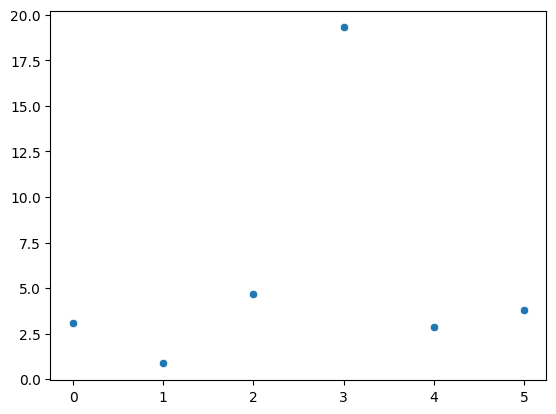

In [20]:
# Here we partition our data for Training and Testing

from sklearn.linear_model import LogisticRegression

# We run a logistic regression model using only our numerical data
X_train, X_test, y_train, y_test = train_test_split(X_norm_df[num_cols],
                                                    y,
                                                    test_size=0.3,
                                                    random_state = 42)
logit_reg = LogisticRegression()
regmodel = logit_reg.fit(X_train, y_train)

print('Coefficients: \n', regmodel.coef_)
sns.scatterplot(x=list(range(0,len(regmodel.coef_[0]))),y=regmodel.coef_[0])

In [21]:
num_cols

['age',
 'fnlwgt',
 'education-num',
 'capital-gain',
 'capital-loss',
 'hours-per-week']

In [22]:
from sklearn.metrics import accuracy_score

yhat_train_predict = logit_reg.predict(X_train)
yhat_test_predict = logit_reg.predict(X_test)

print('\nTrain Accuracy Score (Normalization): %.8f' % accuracy_score(y_train, yhat_train_predict))
print('\nTest Accuracy Scorer (Normalization): %.8f' % accuracy_score(y_test, yhat_test_predict))


Train Accuracy Score (Normalization): 0.80582194

Test Accuracy Scorer (Normalization): 0.80525480


In [23]:
# Here we standardize the numerical columns
num_cols = X.select_dtypes(include=['int', 'float']).columns.tolist()
cat_cols = X.select_dtypes(include=['object']).columns.tolist()

transformers = [
    ('STD', StandardScaler(), num_cols)
]

ct = ColumnTransformer(transformers, remainder='passthrough')
transformed = ct.fit_transform(X)

cols = num_cols + cat_cols

X_std_df = pd.DataFrame(transformed, columns=cols)
X_std_df.head()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass,education,marital-status,occupation,relationship,race,sex,native-country
0,0.014601,-1.059607,1.122624,0.139148,-0.21902,-0.057807,State-gov,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,United-States
1,0.828962,-1.004673,1.122624,-0.147188,-0.21902,-2.256969,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,United-States
2,-0.059431,0.249804,-0.441839,-0.147188,-0.21902,-0.057807,Private,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,United-States
3,1.05106,0.430626,-1.22407,-0.147188,-0.21902,-0.057807,Private,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,United-States
4,-0.799759,1.413543,1.122624,-0.147188,-0.21902,-0.057807,Private,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,Cuba


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Coefficients: 
 [[0.57287416 0.06713361 0.8123404  2.48019964 0.28600562 0.48561301]]


<Axes: >

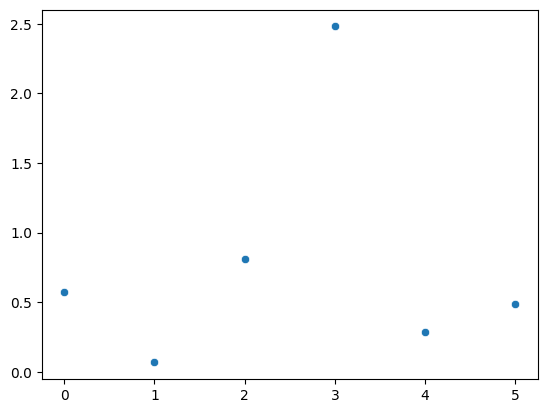

In [24]:
# Here we partition our data for Training and Testing

from sklearn.linear_model import LogisticRegression

# We run a logistic regression model using only our numerical data
X_train, X_test, y_train, y_test = train_test_split(X_std_df[num_cols],
                                                    y,
                                                    test_size=0.3,
                                                    random_state = 42)
logit_reg = LogisticRegression()
regmodel = logit_reg.fit(X_train, y_train)

print('Coefficients: \n', regmodel.coef_)
sns.scatterplot(x=list(range(0,len(regmodel.coef_[0]))),y=regmodel.coef_[0])

In [25]:
yhat_train_predict = logit_reg.predict(X_train)
yhat_test_predict = logit_reg.predict(X_test)

print('\nTrain Accuracy Score (Standardization): %.8f' % accuracy_score(y_train, yhat_train_predict))
print('\nTest Accuracy Score (Standardization): %.8f' % accuracy_score(y_test, yhat_test_predict))

# Note we are only using the numerical columns to predict which may explain why
# we have a low accuracy score


Train Accuracy Score (Standardization): 0.80851327

Test Accuracy Score (Standardization): 0.80835860


In [26]:
# Now that we've standardized, I think it's best to use it for logistic regression
# For standardization
X = X_std_df

## Transformation

In [27]:
# Run imputation and then transformation before data visualization so we don't
# map null values, we don't categorize null values, and don't
# map unnecessary columns

# Dropping the 'education' column, since we have education_num and don't need
# the extra column
X.drop('education', axis=1, inplace=True)

# Calculating 'net-capital-gain' and dropping 'capital-gain' and 'capital-loss'
X['net-capital-gain'] = X['capital-gain'] - X['capital-loss']
X.drop(['capital-gain', 'capital-loss'], axis=1, inplace=True)


## Encode (label vs one-hot)

In [28]:
# Encode (label vs one-hot)
# Small note: make sure you run imputation before this function
# so that it doesn't categorize null values with a number

# label encoding
def enumerate_labels(dataset, string_labels):
  df = dataset.copy(deep=True)
  for label in string_labels:
    uniques = df[label].unique();
    conv_dict = {i:j for i,j in zip(uniques, range(1, len(uniques)+1))}
    df[label] = df[label].map(conv_dict)
  return df
X_label = enumerate_labels(X, ['workclass', 'race', 'native-country', 'occupation',
                         'relationship','marital-status', 'sex'])

# one-hot encoding
def encoding_pipeline(dataset, string_labels):
  df = dataset.copy(deep=True)
  encoder = OneHotEncoder(sparse_output=False)
  encoded_columns = encoder.fit_transform(df[string_labels])
  encoded_df = pd.DataFrame(encoded_columns, columns=encoder.get_feature_names_out(string_labels))
  df = pd.concat([df, encoded_df], axis=1)
  df.drop(string_labels, axis=1, inplace=True)
  return df
X_encode = encoding_pipeline(X, ['workclass', 'race', 'native-country', 'occupation',
                         'relationship','marital-status', 'sex'])
print('Label rows and columns:')
print(X_label.shape)
print('Encoding rows and columns:')
print(X_encode.shape)
#for this dataset, it may be better to use label encoding as we have many ordinal categorical features.

Label rows and columns:
(46180, 12)
Encoding rows and columns:
(46180, 89)


In [29]:
# Label encoding imposes an ordinal relationship, but its less confusing ...
X = X_label

# Let's also encode our target
#y.loc[y['income'] == '>50K', 'income'] = 1
#y.loc[y['income'] == '<=50K', 'income'] = 0

y['income'] = y['income'].map({'>50K': 1, '<=50K': 0})


print(y.value_counts())
print(y['income'].unique())

print(X.shape)
print(y.shape)


income
0         34691
1         11489
dtype: int64
[0 1]
(46180, 12)
(46180, 1)


# Data Exploration (subsample + visualizations):

## Look at subsample of observations

In [30]:
# Look at subsample of observations
X.sample(n=50,random_state=99)

,age,fnlwgt,education-num,hours-per-week,workclass,marital-status,occupation,relationship,race,sex,native-country,net-capital-gain
15794,-0.207497,2.077282,1.904855,1.571202,2,2,4,2,1,1,1,0.071831
19470,-1.243956,-0.339161,1.122624,-0.057807,3,1,4,1,1,1,1,0.071831
23246,-0.725726,-1.474035,-0.441839,0.349445,2,2,8,2,1,1,1,0.071831
31490,1.199126,0.098766,-2.006302,0.593796,3,2,7,2,1,1,1,0.071831
33789,0.014601,-0.691298,-0.050723,0.593796,4,2,1,2,1,1,1,0.071831
38613,-0.207497,-0.550783,-0.441839,-0.057807,3,2,10,2,1,1,1,0.071831
24823,-1.021857,-0.536649,-0.441839,0.756697,3,1,15,1,1,2,1,0.071831
13377,-0.133464,1.011041,-0.441839,-0.057807,3,1,10,1,1,1,1,0.071831
34412,-1.317988,-0.410751,-0.050723,1.571202,3,2,7,2,1,1,1,1.033047
38004,-0.651694,0.231565,1.904855,0.756697,3,1,4,1,1,1,1,0.071831


##Visualize the data

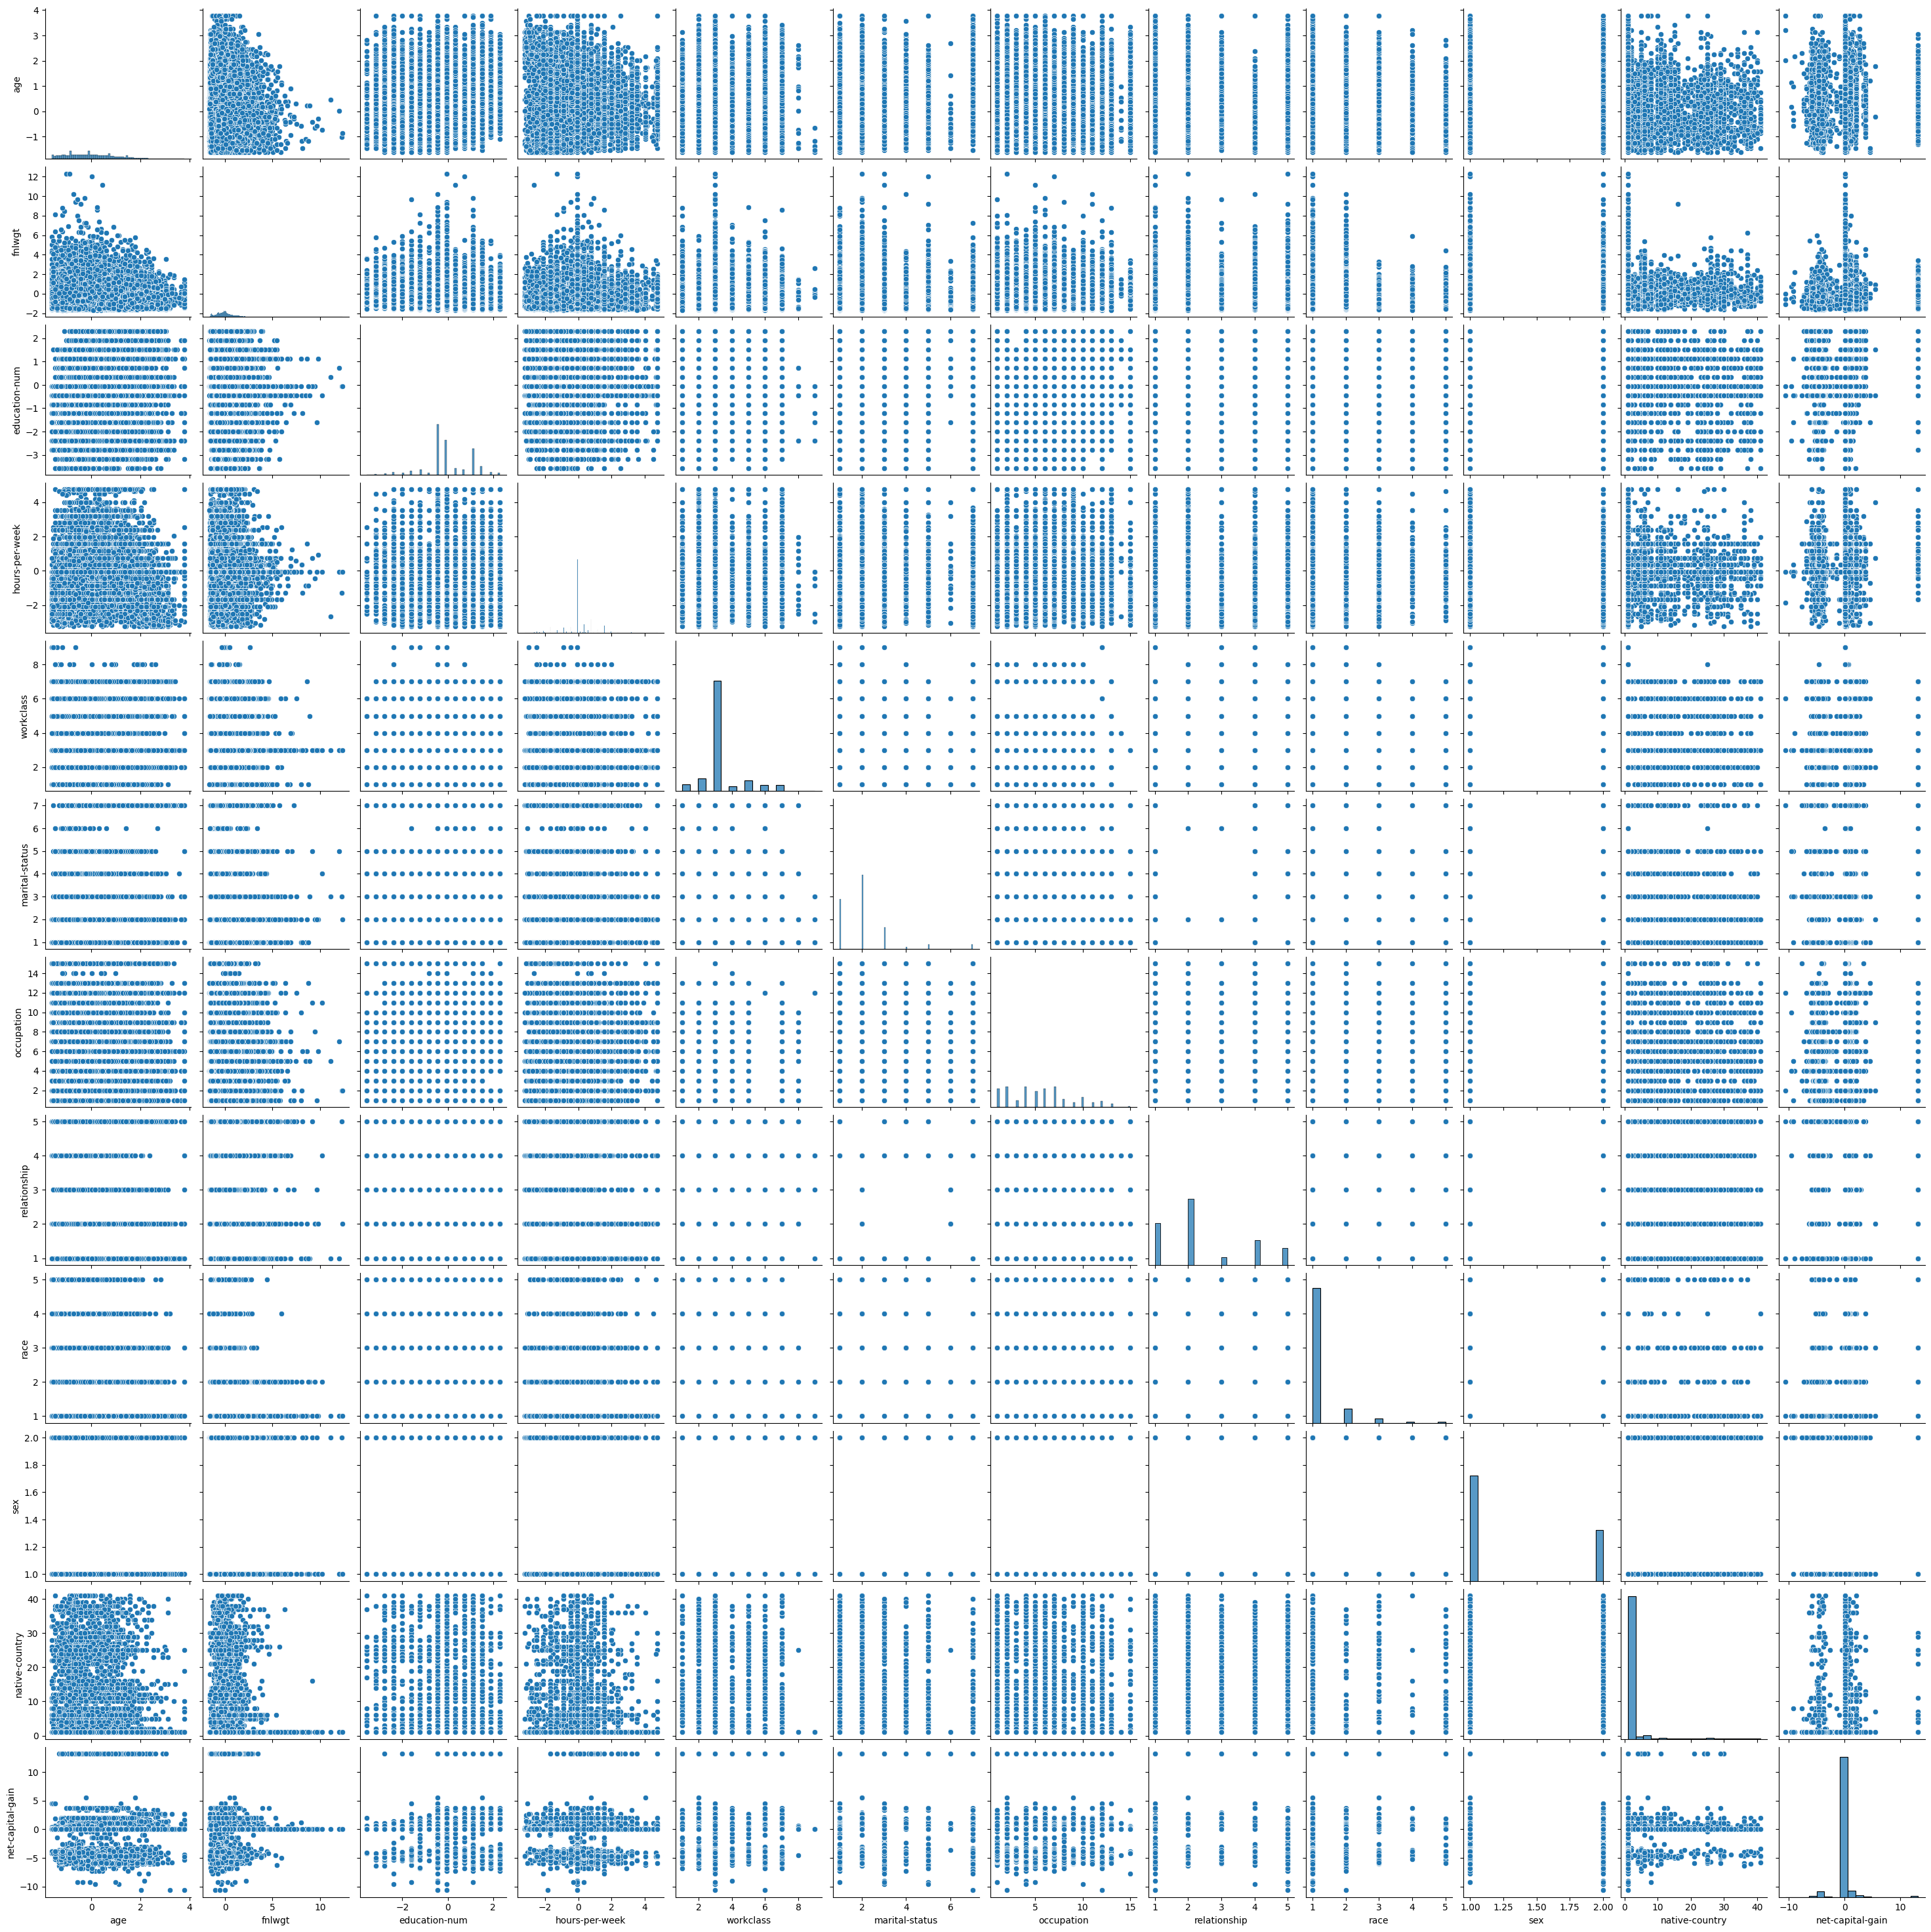

In [31]:
# Visualize the data

# Important note:
# Run imputation and then transformation before data visualization! This is so
# we don't map null values, we don't categorize null values, and don't
# map unnecessary columns

sns.pairplot(X)

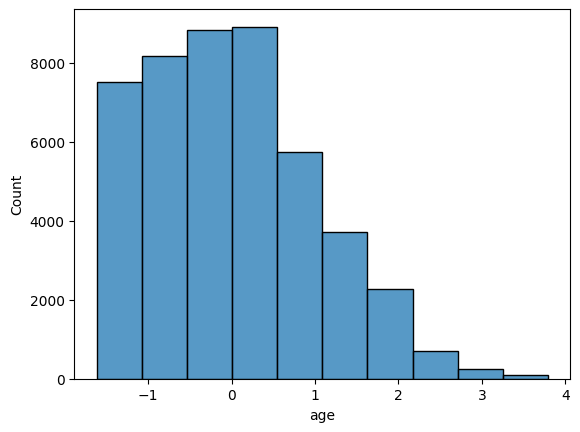

In [32]:
# (Larry Mei) I will make the plots better later (like add titles or something)
sns.histplot(X['age'], bins=10);

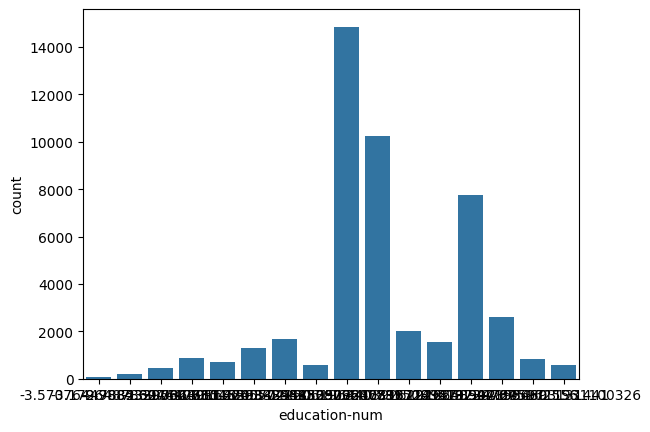

In [33]:
sns.countplot(x='education-num', data=X);

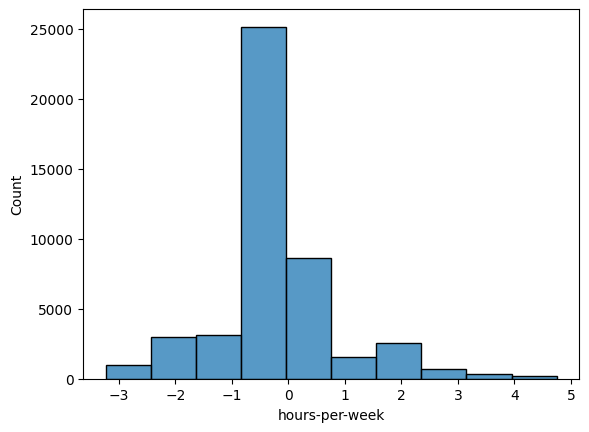

In [34]:
sns.histplot(X['hours-per-week'], bins=10);

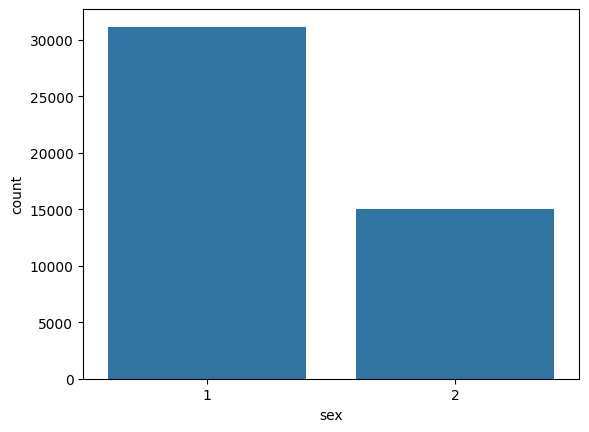

In [35]:
sns.countplot(x='sex', data=X);

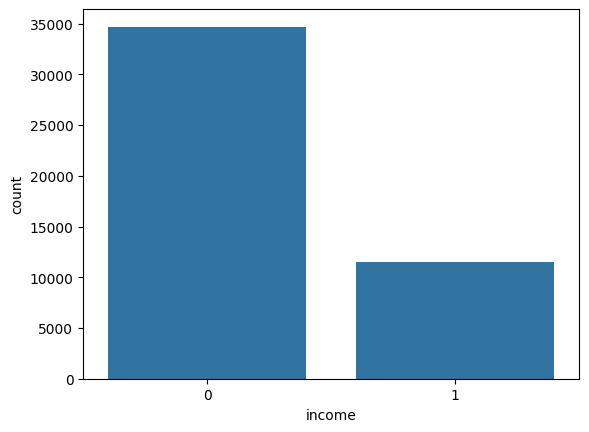

In [36]:
sns.countplot(x='income', data=y);

# Train your model 1


In [37]:
# seems we have already trained the model earlier
# we should likely move the training forwards
trainX, testX, trainY, testY = train_test_split(X,y,test_size=0.2,random_state = 21)

# apparently you need to do this for logistic regression since it doesn't work
# with objects. Making the dependent variable an int.
trainY = trainY.astype('int')
testY = testY.astype('int')

# Let's see these logistics
from sklearn.linear_model import LogisticRegression

# Fit model. Max iter = 5000 for arbitrary reasons
logreg = LogisticRegression(max_iter = 5000)
logreg.fit(trainX, trainY)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(max_iter=5000)

## Evaluate your model compare training vs test error

In [38]:
# calculate training and test error using sklearn.metrics.log_loss (logistic regression uses log loss)
# log_loss(y_test, yhat_test)
# log_loss(y_train, yhat_train)

# Make your bets
yhat_test = logreg.predict(testX)
yhat_train = logreg.predict(trainX)

# 0 is <=50K
# 1 is >50K
from sklearn.metrics import classification_report, confusion_matrix
print("Testing:")
print(classification_report(testY, yhat_test))
print("Training:")
print(classification_report(trainY, yhat_train))

# log loss since we're doing logistic regression
# we use predict_proba to reflect what the model actually predicts
# before filtering it with 1 or 0
from sklearn.metrics import log_loss
log_loss_test = log_loss(testY, logreg.predict_proba(testX))
log_loss_train = log_loss(trainY, logreg.predict_proba(trainX))
print(f"Log Loss (Test): {log_loss_test}")
print(f"Log Loss (Train): {log_loss_train}")


# There's some class imbalance which is why it performs so much worse on
# 1, >50K

Testing:
              precision    recall  f1-score   support

           0       0.83      0.93      0.87      6990
           1       0.64      0.39      0.48      2246

    accuracy                           0.80      9236
   macro avg       0.73      0.66      0.68      9236
weighted avg       0.78      0.80      0.78      9236

Training:
              precision    recall  f1-score   support

           0       0.82      0.93      0.87     27701
           1       0.66      0.39      0.49      9243

    accuracy                           0.80     36944
   macro avg       0.74      0.66      0.68     36944
weighted avg       0.78      0.80      0.78     36944

Log Loss (Test): 0.434118150612765
Log Loss (Train): 0.4354051017069294


## Where does your model fit in the fitting graph?

It's consistent throughout the testing and training predictions, and the log loss values are very close. We have high precision and recall for Class 0 (<=50K) but lower precision and significantly lower recall for Class 1 (>50K), likely due to the class imbalance (6000 samples for Class 0 but 2000 for Class 1).

The model is well fit with good generalization, but definitely could benefit from reducing the amount of samples for class 0. We think that it might fit within the ideal range for model complexity, as errors on both test data and train data are low.

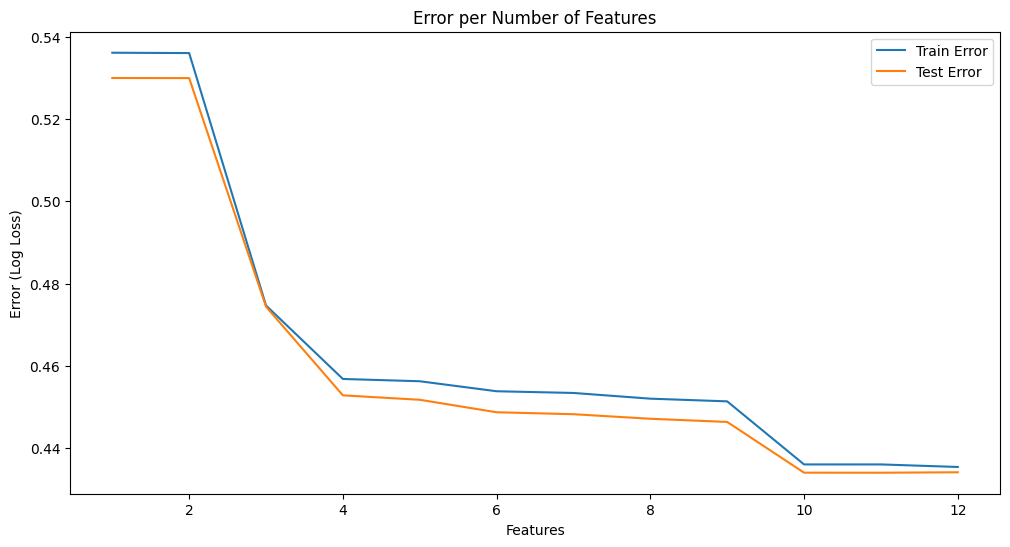

In [39]:
# if the training error is low and the testing error is high, overfit
# if both are high, underfit
# if neither are that high, it's well fit
import matplotlib.pyplot as plt
train_losses = []
test_losses = []
features = range(1, X.shape[1]+1)
trainY_array = np.array(trainY).flatten()
testY_array = np.array(testY).flatten()
for num_features in features:
    logreg_temp = LogisticRegression(max_iter = 5000)
    logreg_temp.fit(trainX.iloc[:, :num_features], trainY_array)
    train_loss = log_loss(trainY_array, logreg_temp.predict_proba(trainX.iloc[:, :num_features]))
    test_loss = log_loss(testY_array, logreg_temp.predict_proba(testX.iloc[:, :num_features]))
    train_losses.append(train_loss)
    test_losses.append(test_loss)

plt.figure(figsize=(12, 6))
plt.plot(features, train_losses, label='Train Error')
plt.plot(features, test_losses, label='Test Error')
plt.xlabel('Features')
plt.ylabel('Error (Log Loss)')
plt.title('Error per Number of Features')
plt.legend()
plt.show()

## What are the next 2 models you are thinking of and why?

We are thinking of using SVM classification to classify who gets what income. We plan on using SVM classification specifically because it is very useful in binary classification and, more importantly, there are methods for us to able to penalize misclassification of the minority class. Additionally, for our second model, we can use a Keras ANN since those are often used to perform prediction / classification tasks with high effectiveness.

## (Update your readme with this info added to the readme with links to the jupyter notebook!)

## Conclusion section: What is the conclusion of your 1st model? What can be done to possibly improve it?



Please make sure preprocessing is complete and your first model has been trained, and predictions for train, val and test are done and analyzed.

We can conclude that our first model has a high accuracy rate for predicting if someone makes less than or equal to 50k, but is much weaker for predicting if they make more than 50k. This was because there was less data for those making over 50k, which led to worse predictions. For future models, we may try making adjustments to the data to reduce the impact of the unbalanced data, or using models that perform relatively well regardless of the number of input entries. We could also perform multiple training runs exclusively on the entries that have income over 50k, to make sure that the model gets to work with it more.



# Evaluation of data, labels, loss function for model 1 before starting model 2


They appear to be sufficient due to our first model's performance on the initial values we had for them. If our second model has a far weaker performance in comparison, we will consider making changes as necessary.

# Train your model 2


In [43]:
# new split of train/test vars
trainX_2, testX_2, trainY_2, testY_2 = train_test_split(X,y,test_size=0.2,random_state = 99)

display(X_train.shape)
display(y_train.shape)

from keras.models import Sequential
from keras.layers import Dense

# initialize ANN
classifier = Sequential()

# input layer
classifier.add(Dense(units = 512, activation = 'relu', input_dim = 12))

# hidden layers
classifier.add(Dense(units = 256, activation = 'relu'))
classifier.add(Dense(units = 128, activation = 'relu'))
classifier.add(Dense(units = 64, activation = 'relu'))
classifier.add(Dense(units = 32, activation = 'relu'))
classifier.add(Dense(units = 16, activation = 'relu'))
classifier.add(Dense(units = 8, activation = 'relu'))
classifier.add(Dense(units = 4, activation = 'relu'))
classifier.add(Dense(units = 2, activation = 'relu'))

# output layer
classifier.add(Dense(units = 1, activation = 'sigmoid'))

# takes a long time to train because of large dataset, change batch_size/epochs if necessary
classifier.compile(optimizer = 'sgd', loss = 'binary_crossentropy')
history = classifier.fit(trainX_2.astype(int), trainY_2.astype(int), batch_size = 300, epochs = 100)


(32326, 6)

(32326, 1)

Epoch 1/100
124/124 [==============================] - 4s 20ms/step - loss: 0.5424
Epoch 2/100
124/124 [==============================] - 3s 26ms/step - loss: 0.4968
Epoch 3/100
124/124 [==============================] - 2s 20ms/step - loss: 0.4566
Epoch 4/100
124/124 [==============================] - 2s 17ms/step - loss: 0.4350
Epoch 5/100
124/124 [==============================] - 1s 11ms/step - loss: 0.4245
Epoch 6/100
124/124 [==============================] - 1s 11ms/step - loss: 0.4195
Epoch 7/100
124/124 [==============================] - 1s 11ms/step - loss: 0.4118
Epoch 8/100
124/124 [==============================] - 1s 11ms/step - loss: 0.4062
Epoch 9/100
124/124 [==============================] - 2s 17ms/step - loss: 0.4024
Epoch 10/100
124/124 [==============================] - 2s 13ms/step - loss: 0.3994
Epoch 11/100
124/124 [==============================] - 1s 11ms/step - loss: 0.3924
Epoch 12/100
124/124 [==============================] - 1s 11ms/step - loss: 0.3900
E

# Evaluation of data, labels, loss function for model 2 before starting model 3
(From instructions: Evaluate your model compare training vs test error)

In [44]:
y_pred_prob = classifier.predict(np.asarray(testX_2).astype(np.float32))
y_pred = (y_pred_prob > 0.5).astype(int)
y_pred_flat = y_pred.ravel()

print("Testing:")
print(classification_report(testY_2, y_pred_flat))

y_pred_prob = classifier.predict(np.asarray(trainX_2).astype(np.float32))
y_pred = (y_pred_prob > 0.5).astype(int)
y_pred_flat = y_pred.ravel()

print("Training:")
print(classification_report(trainY_2, y_pred_flat))

289/289 [==============================] - 1s 2ms/step
Testing:
              precision    recall  f1-score   support

           0       0.88      0.90      0.89      6955
           1       0.68      0.63      0.65      2281

    accuracy                           0.84      9236
   macro avg       0.78      0.77      0.77      9236
weighted avg       0.83      0.84      0.83      9236

1155/1155 [==============================] - 2s 2ms/step
Training:
              precision    recall  f1-score   support

           0       0.89      0.91      0.90     27736
           1       0.71      0.65      0.68      9208

    accuracy                           0.85     36944
   macro avg       0.80      0.78      0.79     36944
weighted avg       0.84      0.85      0.84     36944



In [45]:
log_loss_test = log_loss(testY_2, (classifier.predict(np.asarray(testX_2).astype(np.float32)) > 0.5).astype(int))
log_loss_train = log_loss(trainY_2, (classifier.predict(np.asarray(trainX_2).astype(np.float32)) > 0.5).astype(int))

print(log_loss_test)
print(log_loss_train)

1155/1155 [==============================] - 2s 2ms/step
5.931826889503905
5.543526379302828


289/289 [==============================] - 1s 2ms/step


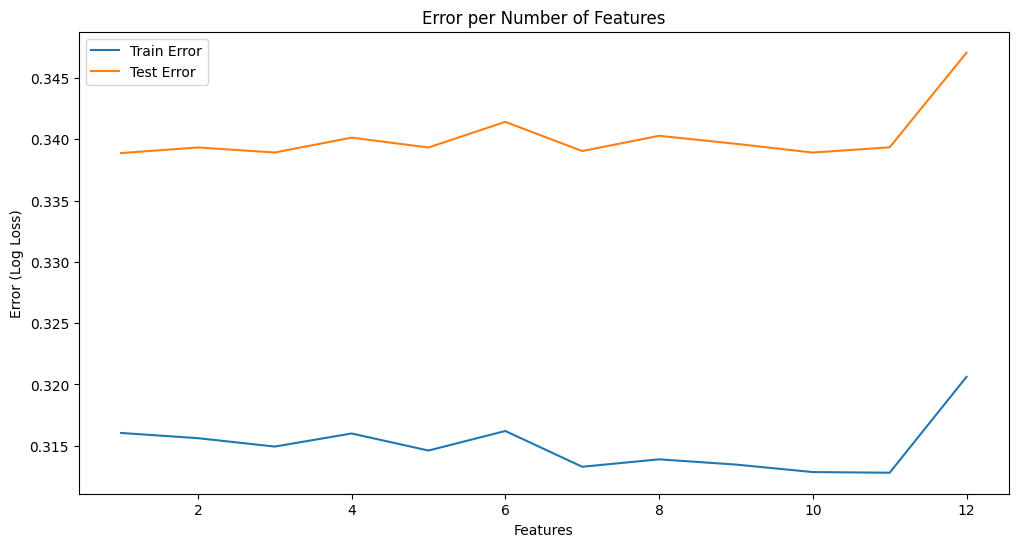

In [46]:
train_losses = []
test_losses = []
features = range(1, X.shape[1]+1)
trainY_array = np.asarray(trainY_2).astype(int)
testY_array = np.asarray(testY_2).astype(int)
for num_features in features:
    classifier.fit(trainX_2.astype(int), trainY_array.astype(int), batch_size = 5000, epochs = 10, verbose = 0)
    train_loss = log_loss(trainY_array, classifier.predict(trainX_2.astype(int)))
    test_loss = log_loss(testY_array, classifier.predict(testX_2.astype(int)))
    train_losses.append(train_loss)
    test_losses.append(test_loss)

plt.figure(figsize=(12, 6))
plt.plot(features, train_losses, label='Train Error')
plt.plot(features, test_losses, label='Test Error')
plt.xlabel('Features')
plt.ylabel('Error (Log Loss)')
plt.title('Error per Number of Features')
plt.legend()
plt.show()

# Where does your model fit in the fitting graph, how does it compare to your first model?


Similarly to the first model, it would fit within the ideal range for model complexity due to the fact that there is a small difference between train and test errors. However, it may lean more towards overfitting since the test error appears to be higher than that of the train error.

# Did you perform hyper parameter tuning? K-fold Cross validation? Feature expansion? What were the results?


In [ ]:
# Cross Validation

In [ ]:
# We may reconstruct the original model but with hyperparameters
!pip install keras_tuner -q
import keras_tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.5 MB/s eta 0:00:00


In [ ]:
from keras.metrics import BinaryAccuracy, BinaryCrossentropy, Precision, Recall
def build_model(hp):
  # initialize ANN8
  classifier = Sequential()
  # input layer
  classifier.add(Dense(units = hp.Int("units", min_value=8, max_value=64, step=2, default=8), activation = 'relu', input_dim = 12))

  for i in range(2):
    classifier.add(Dense(
        units=hp.Int("units", min_value=4, max_value=64, step=2, default=4),
        activation='relu'
    ))

  # hidden layers
  # classifier.add(Dense(units = hp.Int("units", min_value=6, max_value=24, step=6), activation = 'relu'))
  # classifier.add(Dense(units = hp.Int("units", min_value=4, max_value=20, step=5), activation = 'relu'))

  # output layer
  classifier.add(Dense(units = 1, activation = 'sigmoid'))

  # takes a long time to train because of large dataset, change batch_size/epochs if necessary
  # do smaller batch_size/larger epochs for final results to be submitted
  classifier.compile(optimizer = 'sgd', loss = 'binary_crossentropy', metrics=['binary_accuracy'])
  return classifier

# hp_classifier = build_model(keras_tuner.HyperParameters())
# hp_history = hp_classifier.fit(trainX_2.astype(int), trainY_2.astype(int), batch_size = 5000, epochs = 12)


In [ ]:
hp = keras_tuner.HyperParameters()
hp.Int("units", min_value=4, max_value=64)
tuner = keras_tuner.RandomSearch(
    hypermodel=build_model,
    # hyperparameters=keras_tuner.HyperParameters(),
    objective="binary_accuracy",
    max_trials=5,
    executions_per_trial=2,
    tune_new_entries=True,
    allow_new_entries=True,
    seed=15,
    overwrite=True,
    directory="model_2_randomsearch_tuning",
    project_name="151a_milestone_2"
)
tuner.search_space_summary()

Search space summary
Default search space size: 1
units (Int)
{'default': 8, 'conditions': [], 'min_value': 8, 'max_value': 64, 'step': 2, 'sampling': 'linear'}


In [ ]:
tuner.search(trainX_2.astype(int), trainY_2.astype(int), epochs=2)

Trial 5 Complete [00h 00m 18s]
binary_accuracy: 0.8104428350925446

Best binary_accuracy So Far: 0.8104428350925446
Total elapsed time: 00h 01m 24s


In [ ]:
tuner.results_summary()


Results summary
Results in model_2_randomsearch_tuning/151a_milestone_2
Showing 10 best trials
Objective(name="binary_accuracy", direction="max")

Trial 4 summary
Hyperparameters:
units: 46
Score: 0.8104428350925446

Trial 0 summary
Hyperparameters:
units: 62
Score: 0.8091435730457306

Trial 2 summary
Hyperparameters:
units: 38
Score: 0.8073841631412506

Trial 1 summary
Hyperparameters:
units: 28
Score: 0.8009149134159088

Trial 3 summary
Hyperparameters:
units: 18
Score: 0.8002246618270874


In [ ]:
best_models_2 = tuner.get_best_models(num_models=2)

In [ ]:
best_models_2[0].summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 46)                598       
                                                                 
 dense_1 (Dense)             (None, 46)                2162      
                                                                 
 dense_2 (Dense)             (None, 46)                2162      
                                                                 
 dense_3 (Dense)             (None, 1)                 47        
                                                                 
Total params: 4969 (19.41 KB)
Trainable params: 4969 (19.41 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
def gen_graph (model, shape, trainX, trainY, testX, testY):
  train_losses = []
  test_losses = []
  features = range(1, X.shape[1]+1)
  trainY_array = np.asarray(trainY).astype(int)
  testY_array = np.asarray(testY).astype(int)
  for num_features in features:
      model.fit(trainX_2.astype(int), trainY_array.astype(int), batch_size = 5000, epochs = 10, verbose = 0)
      train_loss = log_loss(trainY_array, classifier.predict(trainX_2.astype(int)))
      test_loss = log_loss(testY_array, classifier.predict(testX_2.astype(int)))
      train_losses.append(train_loss)
      test_losses.append(test_loss)
  plt.figure(figsize=(12, 6))
  plt.plot(features, train_losses, label='Train Error')
  plt.plot(features, test_losses, label='Test Error')
  plt.xlabel('Features')
  plt.ylabel('Error (Log Loss)')
  plt.title('Error per Number of Features')
  plt.legend()
  plt.show()

289/289 [==============================] - 0s 1ms/step


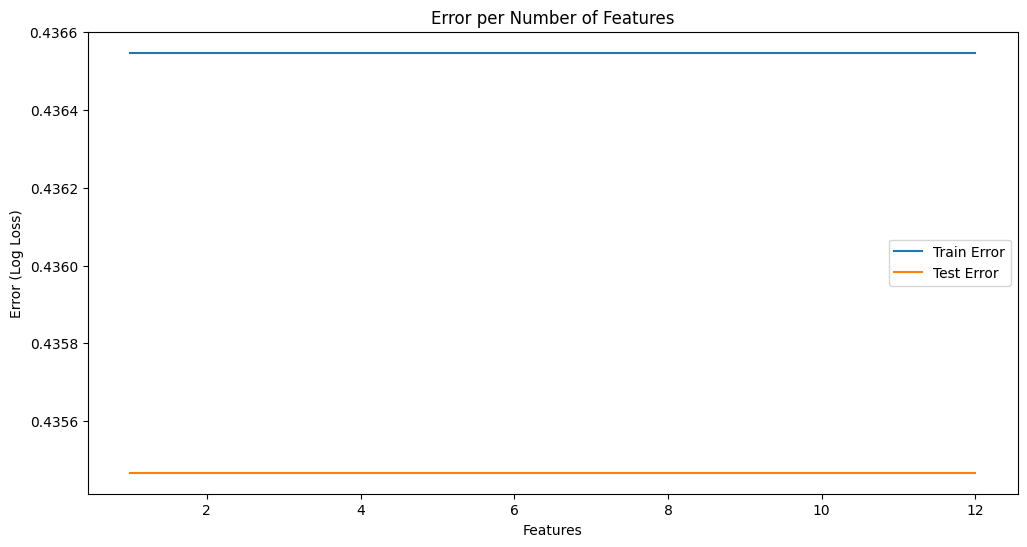

In [ ]:
gen_graph(best_models_2[0], X.shape[1]+1, trainX_2, trainY_2, testX_2, testY_2)

Grid search seems to have created a stable model that has similar levels of test and train error regardless of number of features. However, the training and testing error are both at least above 0.4. More information needs to be uncovered before we can come to a conclusion on what is good. We will do K-fold cross-validation next.

In [ ]:
# split
trainX_2_noval, valX_2, trainY_2_noval, valY_2 = train_test_split(trainX_2, trainY_2, random_state=0)


In [ ]:
hp = keras_tuner.HyperParameters()
hp.Int("units", min_value=4, max_value=64)
tuner = keras_tuner.RandomSearch(
    hypermodel=build_model,
    # hyperparameters=keras_tuner.HyperParameters(),
    objective="binary_accuracy",
    max_trials=5,
    executions_per_trial=2,
    tune_new_entries=True,
    allow_new_entries=True,
    seed=15,
    overwrite=True,
    directory="model_2_randomsearch_tuning_kfold",
    project_name="151a_milestone_2"
)
tuner.search_space_summary()

Search space summary
Default search space size: 1
units (Int)
{'default': 8, 'conditions': [], 'min_value': 8, 'max_value': 64, 'step': 2, 'sampling': 'linear'}


In [ ]:
tuner.search(trainX_2.astype(int), trainY_2.astype(int), epochs=2, validation_data=(valX_2.astype(int), valY_2.astype(int)))

Trial 5 Complete [00h 00m 24s]
binary_accuracy: 0.8108894526958466

Best binary_accuracy So Far: 0.8108894526958466
Total elapsed time: 00h 01m 48s


289/289 [==============================] - 0s 1ms/step


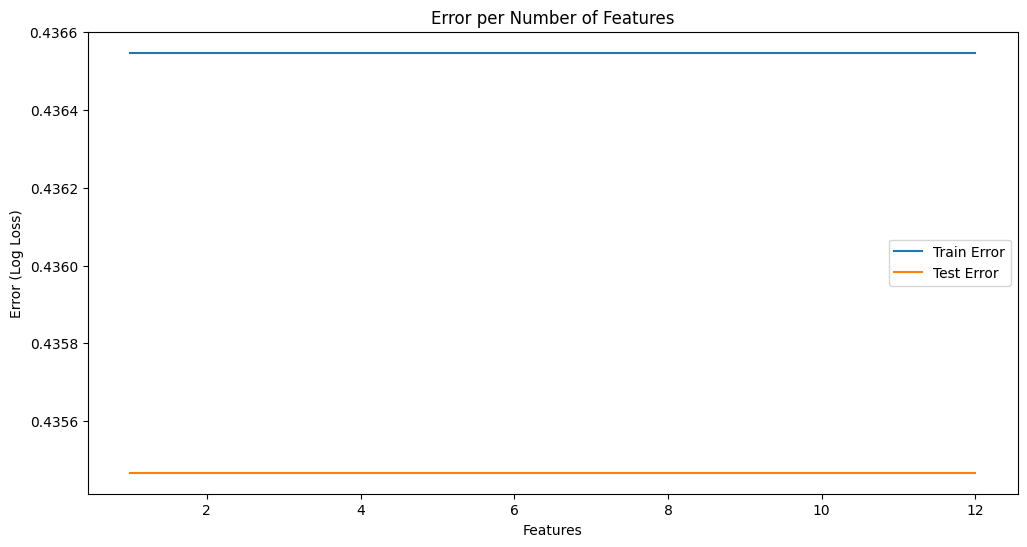

In [ ]:
best_models_2_val = tuner.get_best_models()
gen_graph(best_models_2_val[0], X.shape[1]+1, trainX_2, trainY_2, testX_2, testY_2)

289/289 [==============================] - 0s 1ms/step


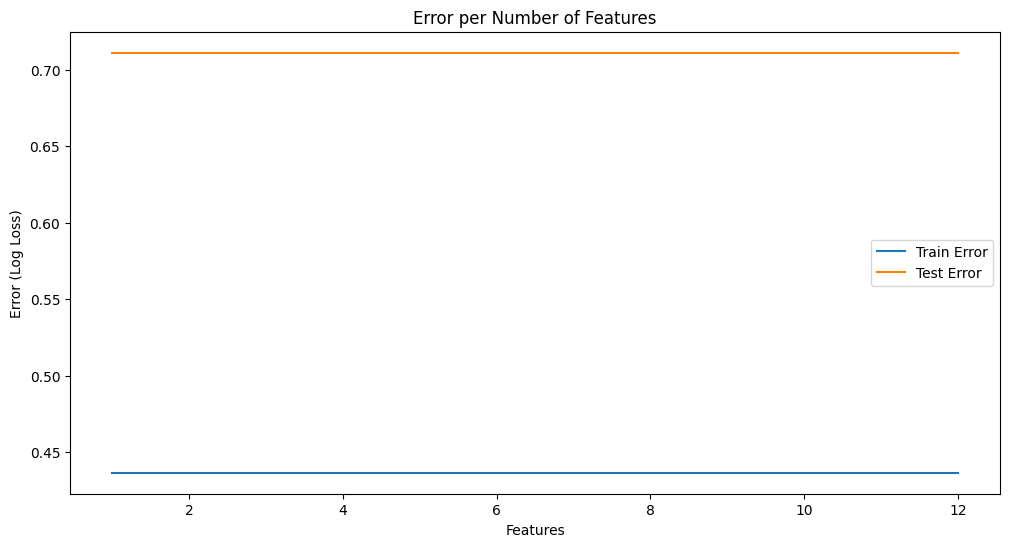

In [ ]:
gen_graph(best_models_2_val[0], X.shape[1]+1, trainX_2, trainY_2, valX_2, valY_2)

Testing on validation seems to show that there is significant difference between validation and testing data. This seems to indicate significant overfitting that was previously unaddressed. More research needs to be done on the previous model to see if this was an issue before.

In [ ]:
best_models_2_val[0].summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 46)                598       
                                                                 
 dense_1 (Dense)             (None, 46)                2162      
                                                                 
 dense_2 (Dense)             (None, 46)                2162      
                                                                 
 dense_3 (Dense)             (None, 1)                 47        
                                                                 
Total params: 4969 (19.41 KB)
Trainable params: 4969 (19.41 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# What is the plan for the next model you are thinking of and why?


To figure out what features might be most important, we could use decision trees. Overfitting seems like an issue, however, so careful planning would need to be done.

Naive Bayes is not likely to be a good idea because most of the features are likely not independent. If we use it to figure out which features correlate with the target, we would have to carefully choose only the most independent features. We could still try it, but we expect bad results.

We are also interested in K-Nearest Neighbors classification because of the unsupervised nature of the approach. It seems useful for exploration because it makes less assumptions about the data. We might be able to use it to lead up to other forms of classification, or as an additional verification measure for decision tree learning.

Finally, we are interested in SVM classification for the simple nature of the model. We expect to achieve relatively quick results using it with some polynomial transformations.

In the end, we may use all of these methods (minus Naive Bayes) and take an average, using majority vote to generalize the model. Some models might be better for some features, and we could leverage it for much benefit.

# Conclusion section: What is the conclusion of your 2nd model? What can be done to possibly improve it? How did it perform to your first and why?


In conclusion, we did not find significant improvements by using a neural network. We found good accuracy, but significant overfitting. We believe neither model is truly sufficient, so we would like to try several others.

# Train your model 3